# [QUEST 평가기준]
1. Transformer와 비교해 변경이 필요한 부분을 서술하였다.
    - 제출 노트북 파일 첫부분에 텍스트 블럭으로 서술합니다. 아키텍쳐 상 변경사항을 블럭단위로 서술합니다.
    - 코드블럭에 변경사항을 주석으로 표시합니다.
2. 모델의 입력 형태에 맞게 전처리를 수행하였다.
    - Decoder 기반의 생성모델임을 감안하여 챗봇 데이터를 변형합니다.
    - 이번 과제는 pretrain을 위한 데이터셋과 학습만 고려합니다.
3. 모델의 입력 블럭을 GPT 논문에 기반하여 수정하였다.
    - 모델의 input이 정상적으로 구성되었는지 확인합니다.
    - 데이터에 위치 정보를 추가하는 과정을 구현합니다.
4. GPT 모델을 정상적으로 구성하였다.(model.summary, model.fit 결과 캡쳐 첨부)
    - 노드의 transformer 코드를 수정하여 GPT1 모델을 구성합니다.
5. 입력에 따른 출력이 생성되었다.
    - 출력 결과물의 수준에 상관없이 모델이 정상적으로 동작하는지 확인합니다.

In [318]:
!pip install sentencepiece

In [319]:
import pandas as pd
import sentencepiece as spm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torch.nn.utils.rnn import pad_sequence
import torch.nn.functional as F
from torch.optim.lr_scheduler import LambdaLR

import math
import time
import re
import os

# 1. 1번 Transformer와 비교해 변경이 필요한 부분을 서술
- 우선 Encoder는 제외되고 Decoder부분만 사용하기에, Encoder input도 필요가 없다.
    - 추가적으로 Encoder의 최종 출력은 K,V가 Decoder의 Cross-Attention에 input으로 들어가지만 제외되었기에 Cross-Attention도 사용을 하지 않는다.
- 기존 Transformer의 Positional Encoding과 다르게, GPT-1은 Posiotional Embedding을 사용한다.
    - 즉, transformer의 PE는 수식기반으로 사전에 정의하고 진행을 하기에 model train할 경우 학습이 되지 않는다.
    - 그래서 GPT-1은 PE도 학습하게 하기 위해 Token Embedding하는 것처럼 Position Embedding을 진행한다.
- 계속 추가로 작성할 것!!

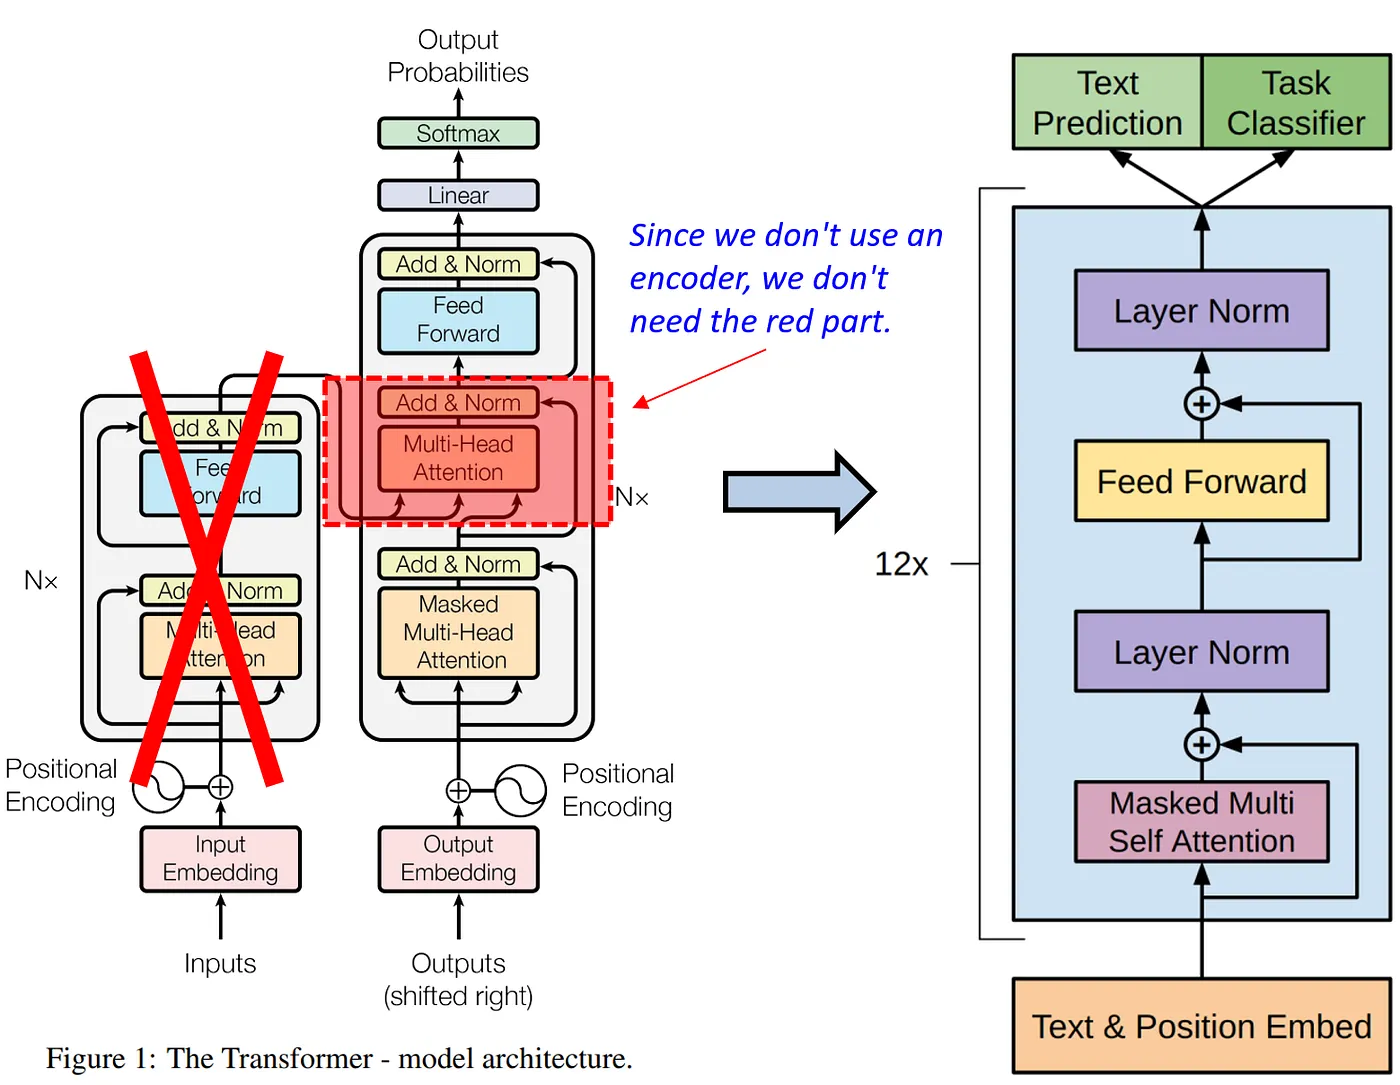
[출처 블로그 - hugmanskj](https://medium.com/@hugmanskj/%EA%B0%80%EC%9E%A5-%EC%84%B1%EA%B3%B5%EC%A0%81%EC%9D%B8-%ED%8A%B8%EB%9E%9C%EC%8A%A4%ED%8F%AC%EB%A8%B8%EC%9D%98-%EB%B3%80%ED%98%95-bert%EC%99%80-gpt-%EC%86%8C%EA%B0%9C-0b18fb7e563b)

# 2. 2번과 3번 동시 진행
- 3번 Positional Embedding부터 2번 Decoder 기반 모델로 전환

- 우선 전에 node 학습하면서 만든 함수들 재사용 - GPT-1에 쓰일거 같은 함수만 가져옴
    - scaled_dot_product_attention -> 수정 필요 X
    - MultiHeadAttention -> 수정 필요 X
    - create_look_ahead_mask, create_padding_mask -> 수정 필요 X
    - DecoderLayer & Decoder -> 수정 필요 O

- 끌고와서 쓰면서, 미리 쓰였던 주석은 그대로 둠 -> #은 기존에 있던거, ##~##은 이번 MainQuest 진행하면서 따로 작성한 것

## 2-1. 기존 코드 수정 필요없는 함수 또는 class
- scaled_dot_product_attention 
- MultiHeadAttention
- create_look_ahead_mask, create_padding_mask 

In [320]:
def scaled_dot_product_attention(query, key, value, mask=None):
    """
    Scaled Dot-Product Attention 계산 함수.

    트랜스포머(Transformer) 구조에서 Query, Key, Value 벡터 간의 유사도를 계산하고,
    그 유사도(Attention Score)를 바탕으로 Value의 가중합을 구함.

    수식:
        Attention(Q, K, V) = softmax( (QK^T) / sqrt(d_k) ) V

    Args:
        query (torch.Tensor): Query 텐서 [batch_size, num_heads, seq_len_q, depth]
        key (torch.Tensor): Key 텐서 [batch_size, num_heads, seq_len_k, depth]
        value (torch.Tensor): Value 텐서 [batch_size, num_heads, seq_len_v, depth_v]
        mask (torch.Tensor, optional): 마스크 텐서 (padding 또는 look-ahead mask). 
                                       0인 위치는 무시됨. 기본값 None.

    Returns:
        tuple[torch.Tensor, torch.Tensor]:
            - output: Attention이 적용된 결과 [batch_size, num_heads, seq_len_q, depth_v]
            - attention_weights: Attention 가중치 행렬 [batch_size, num_heads, seq_len_q, seq_len_k]
    """

    # (1) Query와 Key의 내적 계산 → [batch_size, num_heads, seq_len_q, seq_len_k]
    matmul_qk = torch.matmul(query, key.transpose(-1, -2))

    # (2) 차원 수로 나누어 스케일 조정 (값이 너무 커지는 것을 방지)
    depth = key.size(-1)
    logits = matmul_qk / math.sqrt(depth)

    # (3) 마스크(mask)가 주어지면, 해당 위치는 매우 작은 값(-1e9)으로 채워 softmax 영향 제거
    if mask is not None:
        logits = logits.masked_fill(mask == 0, -1e9)

    # (4) 각 Query에 대해 Key와의 유사도 확률 분포 계산 (softmax)
    attention_weights = F.softmax(logits, dim=-1)

    # (5) Attention 가중치로 Value를 가중합 → 문맥(Context) 벡터 생성
    output = torch.matmul(attention_weights, value)

    return output, attention_weights


In [321]:
class MultiHeadAttention(nn.Module):
    """
    멀티헤드 어텐션(Multi-Head Attention) 모듈.

    트랜스포머의 핵심 구성요소로, 입력 벡터를 여러 개의 '헤드(head)'로 분할하여
    병렬적으로 어텐션을 수행함으로써 서로 다른 의미 공간에서의 관계를 학습하도록 함.

    수식:
        MultiHead(Q, K, V) = Concat(head_1, ..., head_h) W^O
        where head_i = Attention(QW_i^Q, KW_i^K, VW_i^V)

    Args:
        d_model (int): 입력 임베딩 차원 수 (예: 512)
        num_heads (int): 어텐션 헤드의 개수 (예: 8)

    Attributes:
        depth (int): 각 헤드의 임베딩 차원 (d_model / num_heads)
        query_dense (nn.Linear): Query 변환용 선형 레이어
        key_dense (nn.Linear): Key 변환용 선형 레이어
        value_dense (nn.Linear): Value 변환용 선형 레이어
        out_dense (nn.Linear): 여러 헤드의 출력을 다시 합쳐주는 출력 레이어
    """

    def __init__(self, d_model, num_heads):
        super().__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        # (1) d_model이 num_heads로 나누어 떨어져야 함 (각 헤드의 차원이 동일해야 하므로)
        assert d_model % num_heads == 0, "d_model은 num_heads로 나누어 떨어져야 합니다."

        # (2) 각 헤드별 차원 (depth)
        self.depth = d_model // num_heads

        # (3) Query, Key, Value를 위한 선형 변환 레이어 정의
        self.query_dense = nn.Linear(d_model, d_model)
        self.key_dense   = nn.Linear(d_model, d_model)
        self.value_dense = nn.Linear(d_model, d_model)

        # (4) 여러 헤드의 출력을 결합한 후 최종 선형 변환
        self.out_dense   = nn.Linear(d_model, d_model)

    def split_heads(self, x, batch_size):
        """
        입력 텐서를 여러 개의 헤드로 분리하는 함수.

        입력 형태: [batch_size, seq_len, d_model]
        출력 형태: [batch_size, num_heads, seq_len, depth]

        Args:
            x (torch.Tensor): 입력 텐서
            batch_size (int): 배치 크기

        Returns:
            torch.Tensor: 헤드 분할 및 차원 변환된 텐서
        """
        # [batch_size, seq_len, d_model] → [batch_size, seq_len, num_heads, depth]
        x = x.view(batch_size, -1, self.num_heads, self.depth)

        # 어텐션 계산을 위해 차원 순서를 변경
        # [batch_size, num_heads, seq_len, depth]
        return x.permute(0, 2, 1, 3)

    def forward(self, query, key, value, mask=None):
        """
        멀티헤드 어텐션 연산을 수행하는 함수.

        Args:
            query (torch.Tensor): Query 입력 [batch_size, seq_len_q, d_model]
            key (torch.Tensor): Key 입력 [batch_size, seq_len_k, d_model]
            value (torch.Tensor): Value 입력 [batch_size, seq_len_v, d_model]
            mask (torch.Tensor, optional): 어텐션 마스크 (padding 또는 look-ahead). 기본값 None.

        Returns:
            torch.Tensor: 어텐션이 적용된 출력 [batch_size, seq_len_q, d_model]
        """
        batch_size = query.size(0)

        # (1) 입력 벡터를 각각 선형 변환 후, 여러 헤드로 분리
        query = self.split_heads(self.query_dense(query), batch_size)
        key   = self.split_heads(self.key_dense(key), batch_size)
        value = self.split_heads(self.value_dense(value), batch_size)

        # (2) 스케일 조정된 닷프로덕트 어텐션 수행 (각 헤드별로 병렬 계산)
        scaled_attention, _ = scaled_dot_product_attention(query, key, value, mask)

        # (3) 어텐션 결과를 원래 차원 순서로 되돌림
        # [batch_size, num_heads, seq_len_q, depth] → [batch_size, seq_len_q, num_heads, depth]
        scaled_attention = scaled_attention.permute(0, 2, 1, 3).contiguous()

        # (4) 모든 헤드를 하나로 결합 (concat)
        concat_attention = scaled_attention.view(batch_size, -1, self.d_model)

        # (5) 최종 선형 변환을 통해 출력 생성
        output = self.out_dense(concat_attention)

        return output


In [322]:
def create_padding_mask(x, pad_id=0):
    """
    입력 시퀀스 내 패딩 토큰을 감지하여 마스크를 생성하는 함수.

    트랜스포머에서 **패딩 토큰(PAD)** 은 실제 의미가 없으므로,  
    Attention 계산 시 이 위치의 값이 다른 토큰의 연산에 영향을 주지 않도록  
    마스크(mask)를 만들어줌.

    Args:
        x (torch.Tensor): 입력 시퀀스 텐서 [batch_size, seq_len]
        pad_id (int, optional): 패딩 토큰의 ID 값 (기본값: 0)

    Returns:
        torch.Tensor: 패딩 마스크 텐서 [batch_size, 1, 1, seq_len]
                      (1: 유효 토큰, 0: 패딩 위치)
    """
    # pad_id가 아닌 위치는 1(True), pad_id인 위치는 0(False)
    mask = (x != pad_id).unsqueeze(1).unsqueeze(2).float()
    # shape: [batch_size, 1, 1, seq_len]
    return mask


def create_look_ahead_mask(x):
    """
    Decoder에서 미래 토큰을 참조하지 못하도록 'look-ahead mask' 생성
    + 입력 내 패딩(0) 위치 마스킹을 결합한 최종 combined mask 반환

    Args:
        x: [batch_size, seq_len]
    Returns:
        return: [batch_size, 1, seq_len, seq_len]
    """
    seq_len = x.size(1)

    # 1) Look-ahead 마스크 생성
    # torch.ones((seq_len, seq_len)) → 1로 채워진 정방행렬 생성
    # torch.tril() → 하삼각(자기 자신 포함) 부분만 남기고 나머지를 0으로 만듦
    # 1 - tril(...) → 상삼각(즉, 미래 토큰 위치)이 1, 나머지는 0
    # => Decoder가 아직 보지 않은 미래 단어를 참고하지 않도록 차단
    look_ahead_mask = 1 - torch.tril(torch.ones((seq_len, seq_len)))

    # 2) 입력 x에서 패딩 위치(0인 부분)를 찾아 패딩 마스크 생성
    # shape: (batch_size, 1, 1, seq_len)
    padding_mask = create_padding_mask(x)

    # 3) Look-ahead 마스크 차원 확장
    # (seq_len, seq_len) → (1, seq_len, seq_len) → (1, 1, seq_len, seq_len)
    # => Attention 연산 시 브로드캐스팅이 가능하도록 형태 맞춤
    look_ahead_mask = look_ahead_mask.unsqueeze(0).unsqueeze(1)
    look_ahead_mask = look_ahead_mask.to(x.device)

    # 4) Look-ahead 마스크와 패딩 마스크를 결합
    # torch.max()를 사용하여 둘 중 하나라도 1인 위치는 모두 마스킹 처리
    # 최종 shape: (batch_size, 1, seq_len, seq_len)
    combined_mask = torch.max(look_ahead_mask, padding_mask)
    
    return combined_mask

## 2-2. 변경된 Decoder Layer와 Decoder

In [323]:
class DecoderLayer(nn.Module):
    ## GPT-1은 Transformer와 Decoder의 구조가 다르다 ##
    ## Masked Self-Attention - FFNN 으로만 이어져있다 ##
    ## 물론 저 사이사이에 Residual + LayerNorm은 그대로 존재 ##
    ## 논문으로는 Transformer와 GPT-1은 Post-LN이면 GPT-2부터 Pre-LN이라고 한다. ##
    
    def __init__(self, d_model, num_heads, ff_dim, dropout=0.1):
        super().__init__()

        # 디코더의 Self-Attention (미래 토큰 가리기)
        self.self_mha = MultiHeadAttention(d_model, num_heads)

        ## 기존 Cross-Attention 삭제 ##
        
        # Position-wise Feed Forward Network
        self.ffn = nn.Sequential(
            nn.Linear(d_model, ff_dim),
            nn.GELU(), ## paper 상에서는 ReLU말고 GeLU 사용함 ##
            nn.Linear(ff_dim, d_model)
        )

        # 각 블록 뒤의 Layer Normalization
        self.norm1 = nn.LayerNorm(d_model, eps=1e-6)
        self.norm2 = nn.LayerNorm(d_model, eps=1e-6)

        # Dropout (과적합 방지용)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, x, look_ahead_mask):
        """
        x: 디코더 입력 (target embedding)
        enc_output: 인코더 출력 (context)
        look_ahead_mask: 미래 단어 마스킹
        padding_mask: 인코더 패딩 마스크
        """

        # -------------------------------
        # Masked Self-Attention
        #  - 자기 자신 문장에서 미래 단어를 보지 않도록 마스크 적용
        # -------------------------------
        self_attn = self.self_mha(x, x, x, look_ahead_mask)
        self_attn = self.dropout1(self_attn)
        out1 = self.norm1(x + self_attn)  # 잔차연결 + 정규화

        # -------------------------------
        # Feed Forward Network
        #  - 각 위치별 독립적 비선형 변환
        # -------------------------------
        ffn_out = self.ffn(out1)
        ffn_out = self.dropout2(ffn_out)
        out2 = self.norm2(out1 + ffn_out)

        return out2 

class Decoder(nn.Module):
    def __init__(self, vocab_size, num_layers, ff_dim, d_model, num_heads, max_len=200, dropout=0.1):
        super().__init__()

        self.d_model = d_model

        # (1) 단어 임베딩 레이어
        #   - 토큰 인덱스를 d_model 차원의 벡터로 변환
        self.embedding = nn.Embedding(vocab_size, d_model, padding_idx=0)

        ## (2) 위치 임베딩 (Positional Embedding) ##
        ## Transformer의 PE와 달리, 단순히 Embedding을 통해 진행 ##
        self.pos_embedding = nn.Embedding(max_len, d_model)

        # (3) Dropout
        self.dropout = nn.Dropout(dropout)

        # (4) 디코더 층 여러 개 쌓기
        self.dec_layers = nn.ModuleList([
            DecoderLayer(d_model, num_heads, ff_dim, dropout)
            for _ in range(num_layers)
        ])

    def forward(self, x, look_ahead_mask):
        """
        x: 디코더 입력 (target 문장, [batch_size, tgt_seq_len])
        enc_output: 인코더 출력 (context)
        look_ahead_mask: 디코더용 마스크 (미래 단어 가리기)
        padding_mask: 인코더 입력의 패딩 위치 마스크
        """

        batch_size, seq_len = x.size()
        
        # (1) 임베딩 + √d_model 스케일링 (논문 방식)
        x = self.embedding(x) * math.sqrt(self.d_model)

        ## (2) Positional Embedding 추가 ##
        ## seq_len은 입력 문장의 길이로 그거에 맞춰서 PE 진행 ##
        positions = torch.arange(0, seq_len, device=x.device).unsqueeze(0)  # [1, seq_len]
        pos_emb = self.pos_embedding(positions)  # [1, seq_len, d_model]
        x = x + pos_emb

        # (3) 드롭아웃 적용
        x = self.dropout(x)

        # (4) 여러 개의 디코더 레이어를 순차적으로 통과
        for layer in self.dec_layers:
            x = layer(x, look_ahead_mask)

        # (5) 최종 디코더 출력 반환
        return x # [batch_size, seq_len, d_model]


## 2-3. 최종 GPT-1 model

In [324]:
##Since layernorm is used extensively throughout the model, a simple weight initialization of N(0, 0.02) was sufficient.##
## paper에서는 가중치 초기화도 지정을 했다고 한다. ##
## N(0, 0.02) ##

def weights_init(module):
    """GPT-1 논문 스타일 가중치 초기화"""
    if isinstance(module, (nn.Linear, nn.Embedding)):
        nn.init.normal_(module.weight, mean=0.0, std=0.02)
        if isinstance(module, nn.Linear) and module.bias is not None:
            nn.init.zeros_(module.bias)  # bias는 0으로 초기화
    elif isinstance(module, nn.LayerNorm):
        nn.init.ones_(module.weight)  # LayerNorm gain(γ)
        nn.init.zeros_(module.bias)   # LayerNorm bias(β)

class GPT(nn.Module):
    def __init__(self, vocab_size, num_layers, ff_dim, d_model, num_heads, max_len=200, dropout=0.1):
        ## hyperparameter는 Transformer와 동일함 ##
        super().__init__()
        ## 사실상 구조 자체는 간단해졌기에, Transformer class보다는 굉장히 단순해짐 ##
        self.decoder = Decoder(vocab_size, num_layers, ff_dim, d_model, num_heads, max_len, dropout)

        self.fc_out = nn.Linear(d_model, vocab_size, bias=False)  # LM Head

        self.apply(weights_init) # 가중치 초기화
        
    def forward(self, x):
        ## 그럼 순서대로 진행 ##
        ## masking -> Decoder -> norm -> Linear ##
        mask = create_look_ahead_mask(x)
        dec_output = self.decoder(x, mask)

        logits = self.fc_out(dec_output)
        return logits ## 각 token 위치별 다음 단어 예측하는 확률분포 ##

# 3. 4번 GPT 모델을 정상적으로 구성

## 3-1. Data Preprocessing
- node 학습처럼 진행하되, project 실습처럼 과정을 약간 단순화 시킴

In [325]:
url = 'https://raw.githubusercontent.com/songys/Chatbot_data/master/ChatbotData.csv'
df = pd.read_csv(url)

# 전처리 진행 - 간단하게만
def  preprocess_sentence(sentence):
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = sentence.strip()
    
    return sentence

questions = [preprocess_sentence(q) for q in df['Q']]
answers   = [preprocess_sentence(a) for a in df['A']]

corpus = questions + answers
print('전체 샘플 수 :', len(corpus)/2)
with open('GPT-1/corpus.txt', 'w', encoding='utf-8') as f:
    for s in corpus:
        f.write(s + '\n')

전체 샘플 수 : 11823.0


In [326]:
spm.SentencePieceTrainer.Train(
    input='GPT-1/corpus.txt',
    model_prefix='GPT-1/chatbot_tokenizer',
    vocab_size=8000, 
    model_type='unigram',
    character_coverage=0.9995,
    pad_id=0, unk_id=1, bos_id=2, eos_id=3
)

sp = spm.SentencePieceProcessor(model_file='GPT-1/chatbot_tokenizer.model')

sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: GPT-1/corpus.txt
  input_format: 
  model_prefix: GPT-1/chatbot_tokenizer
  model_type: UNIGRAM
  vocab_size: 8000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  seed_sentencepieces_file: 
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 1
  bos_id: 2
  eos_id: 3
  pad_id: 0
  unk_piece: <unk>
  bos_piece: <s>
  eos_piece: </s>
  pad_piece: <pad>
  unk_surface:  ⁇ 
  enable_differential_

In [327]:
# 특정 문자까지 자르자
# 근데 하다보니 MAX_LEN을 높게 잡다보니 의미가..??
# 저번 Transformer 진행할때, NLP 실습시 사용한 코드로 적정 문장길이 그거로 해봤는데도 성능에 차이는 없었음
def truncate(seq, max_len):
    return seq[:max_len]

MAX_LEN = 100

tokenized_data = []
for q, a in zip(questions, answers):
    if q and a: 
        q_tokens = sp.encode_as_ids(q)
        a_tokens = sp.encode_as_ids(a) 
        
        # <BOS> + 질문 + <EOS> + <BOS> + 답변 + <EOS>로 진행해봄 
        tokens = [sp.bos_id()] + q_tokens + [sp.eos_id()] + [sp.bos_id()] + a_tokens + [sp.eos_id()]
        
        tokens = truncate(tokens, MAX_LEN)
        tokenized_data.append(tokens)


## 3-3. Dataset & DataLoader

In [328]:
class GPT1_Dataset(Dataset):
    def __init__(self, tokenized_data):
        """
        Args:
            tokenized_data : 이미 Q와 A가 하나로 합쳐져서 들어옴
        """
        self.data = tokenized_data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, i):
        """
        i번째 샘플을 텐서 형태로 반환
        """
        return torch.tensor(self.data[i])


def collate(batch):
    # Padding 처리해주는 함수
    input_ids = pad_sequence(batch, batch_first=True, padding_value=sp.pad_id())
    return input_ids



# 전체 데이터셋
full_dataset = GPT1_Dataset(tokenized_data) 

# 80% train, 10% valid, 10% test
train_size = int(0.8 * len(full_dataset))
valid_size = int(0.1 * len(full_dataset))
test_size = len(full_dataset) - train_size - valid_size

train_dataset, valid_dataset, test_dataset = random_split(
    full_dataset, [train_size, valid_size, test_size],
    generator=torch.Generator().manual_seed(42)
)

# collate_fn이 수정되었으므로 DataLoader는 그대로 사용
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=collate)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False, collate_fn=collate)
test_loader  = DataLoader(test_dataset,  batch_size=64, shuffle=False, collate_fn=collate)

print(f"Train: {len(train_dataset)} | Valid: {len(valid_dataset)} | Test: {len(test_dataset)}")

Train: 9458 | Valid: 1182 | Test: 1183


## 3-3. Model Train

In [329]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
VOCAB_SIZE = sp.get_piece_size()
NUM_LAYERS = 12 
FF_DIM = 1024 
D_MODEL = 256 
NUM_HEADS = 8 
NUM_EPOCHS = 20

model = GPT(vocab_size=VOCAB_SIZE, 
            num_layers=NUM_LAYERS, 
            ff_dim=FF_DIM, 
            d_model=D_MODEL, 
            num_heads=NUM_HEADS, 
            max_len=MAX_LEN, 
            dropout=0.3).to(device)

print(model) # 모델 구조

GPT(
  (decoder): Decoder(
    (embedding): Embedding(8000, 256, padding_idx=0)
    (pos_embedding): Embedding(100, 256)
    (dropout): Dropout(p=0.3, inplace=False)
    (dec_layers): ModuleList(
      (0-11): 12 x DecoderLayer(
        (self_mha): MultiHeadAttention(
          (query_dense): Linear(in_features=256, out_features=256, bias=True)
          (key_dense): Linear(in_features=256, out_features=256, bias=True)
          (value_dense): Linear(in_features=256, out_features=256, bias=True)
          (out_dense): Linear(in_features=256, out_features=256, bias=True)
        )
        (ffn): Sequential(
          (0): Linear(in_features=256, out_features=1024, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=1024, out_features=256, bias=True)
        )
        (norm1): LayerNorm((256,), eps=1e-06, elementwise_affine=True)
        (norm2): LayerNorm((256,), eps=1e-06, elementwise_affine=True)
        (dropout1): Dropout(p=0.3, inplace=False)
      

In [330]:
def gpt1_lr_lambda(step):
    warmup_steps = 2000 
    
    if step < warmup_steps:
        return step / warmup_steps
    
    # 웜업 이후 Cosine Decay
    progress = (step - warmup_steps) / (total_steps - warmup_steps)
    return 0.5 * (1 + math.cos(math.pi * progress))

steps_per_epoch = math.ceil(len(train_dataset) / 64) # 64는 train_loader의 batch_size
total_steps = steps_per_epoch * NUM_EPOCHS
print(f"Total training steps calculated: {total_steps} (Epochs: {NUM_EPOCHS}, Steps/Epoch: {steps_per_epoch})")

# GPT-1 paper에서 Adam을 사용했다고 하지만, modified version of L2 regularization 한다고 한다.
# GPT-1 구현한 몇몇 github를 들어가니 Adam이 아닌 AdamW로 구현한 것으로 보고 진행함
#optimizer = torch.optim.Adam(model.parameters(), lr=2.5e-4, betas=(0.9, 0.999), eps=1e-8)
#scheduler = LambdaLR(optimizer, lr_lambda=gpt1_lr_lambda)

# paper상에 with w = 0.01 on all non bias or gain weights 문구가 있다
# 그래서 이부분은 GPT를 통해 단순 구현
decay, no_decay = [], []
for name, param in model.named_parameters():
    if param.requires_grad:
        if 'bias' in name or 'ln' in name or 'norm' in name:
            no_decay.append(param)
        else:
            decay.append(param)

optimizer = torch.optim.AdamW([
    {'params': decay, 'weight_decay': 0.01},
    {'params': no_decay, 'weight_decay': 0.0}
], lr=2.5e-4, betas=(0.9, 0.999), eps=1e-8)

scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=gpt1_lr_lambda)
criterion = nn.CrossEntropyLoss(ignore_index=sp.pad_id())

Total training steps calculated: 2960 (Epochs: 20, Steps/Epoch: 148)


In [331]:
def train_step(model, batch, optimizer, loss_function, device):
    """
    한 epoch 동안 모델 학습 수행

    Args:
        model: Transformer 모델
        batch : 
        optimizer: 옵티마이저 (예: AdamW)
        loss_function: 손실 함수
        device: CPU 또는 GPU
    """
    model.train()
    
    input_ids = batch.to(device) # [Batch, SeqLen]

    # '교사 강요'를 위해 합쳐져 있는 값을 입력과 타겟 분리함
    # 입력 : [<s>, Q, </s>, <s>, A]
    # 타겟 : [Q, </s>, <s>, A, </s>]
    inputs = input_ids[:, :-1]
    targets = input_ids[:, 1:]

    optimizer.zero_grad()
    logits = model(inputs) # [Batch, SeqLen-1, VocabSize]
    loss = loss_function(logits.permute(0, 2, 1), targets)

    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) # Gradient Clipping
    optimizer.step()

    return loss.item()
    
def train_model(model, train_loader, valid_loader,
                optimizer, scheduler, loss_function,
                device, num_epochs=10, 
                save_dir="GPT-1/checkpoints"):  
    """
    전체 학습 루프를 수행하고 best 모델 저장

    Args:
        model: Transformer 모델
        train_loader, valid_loader: DataLoader
        optimizer, scheduler, criterion: 학습 구성요소
        device: torch.device("cuda" or "cpu")
        num_epochs: 학습 epoch 수
        save_dir: 모델 저장 경로
    """
    os.makedirs(save_dir, exist_ok=True)
    best_val_loss = float('inf')
    model.to(device)

    for epoch in range(1, num_epochs + 1):
        start_time = time.time()
        total_loss = 0.0

        for step, batch in enumerate(train_loader):
            loss = train_step(model, batch, optimizer, loss_function, device)
            total_loss += loss
            scheduler.step()
            
            if (step + 1) % 100 == 0:
                lr = scheduler.get_last_lr()[0]
                print(f"[Epoch {epoch}, Step {step+1}] Loss: {loss:.4f}, LR: {lr:.6f}")

        avg_train_loss = total_loss / len(train_loader)
        
        val_loss = evaluate(model, valid_loader, loss_function, device)
        val_ppl = math.exp(val_loss) # Perplexity

        # Best 모델 저장
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), os.path.join(save_dir, "best_model.pth"))
            print(f"[SAVE] Best model saved | Val Loss: {val_loss:.4f}")

        print(f"Epoch {epoch} Completed - Train Loss: {avg_train_loss:.4f} | "
              f"Val Loss: {val_loss:.4f} | Val PPL: {val_ppl:.2f} | "
              f"Time: {time.time() - start_time:.1f}s\n")

In [332]:
@torch.no_grad()
def evaluate(model, loader, loss_function, device):
    """
    검증 데이터셋에 대한 평균 손실 계산

    Args:
        model: Transformer 모델
        loader: 검증용 DataLoader
        crit: 손실 함수 (예: nn.CrossEntropyLoss)
        device: CPU 또는 GPU 장치
    """
    model.eval()
    total_loss = 0.0

    for batch in loader:
        input_ids = batch.to(device)

        inputs = input_ids[:, :-1]
        targets = input_ids[:, 1:]

        logits = model(inputs)
        loss = loss_function(logits.permute(0, 2, 1), targets)
        total_loss += loss.item()

    return total_loss / len(loader)

In [333]:
train_model(model, train_loader, valid_loader,
            optimizer, scheduler, criterion,
            device, num_epochs=NUM_EPOCHS, save_dir="GPT-1/checkpoints")

[Epoch 1, Step 100] Loss: 8.1635, LR: 0.000013
[SAVE] Best model saved | Val Loss: 7.7288
Epoch 1 Completed - Train Loss: 8.4854 | Val Loss: 7.7288 | Val PPL: 2272.81 | Time: 10.4s

[Epoch 2, Step 100] Loss: 7.1590, LR: 0.000031
[SAVE] Best model saved | Val Loss: 6.7457
Epoch 2 Completed - Train Loss: 7.2971 | Val Loss: 6.7457 | Val PPL: 850.41 | Time: 10.6s

[Epoch 3, Step 100] Loss: 5.9957, LR: 0.000050
[SAVE] Best model saved | Val Loss: 5.8654
Epoch 3 Completed - Train Loss: 6.3147 | Val Loss: 5.8654 | Val PPL: 352.62 | Time: 10.8s

[Epoch 4, Step 100] Loss: 5.4729, LR: 0.000068
[SAVE] Best model saved | Val Loss: 5.3508
Epoch 4 Completed - Train Loss: 5.6100 | Val Loss: 5.3508 | Val PPL: 210.78 | Time: 10.7s

[Epoch 5, Step 100] Loss: 5.1433, LR: 0.000087
[SAVE] Best model saved | Val Loss: 4.9642
Epoch 5 Completed - Train Loss: 5.1390 | Val Loss: 4.9642 | Val PPL: 143.19 | Time: 10.5s

[Epoch 6, Step 100] Loss: 4.7369, LR: 0.000105
[SAVE] Best model saved | Val Loss: 4.6199
Epoc

In [334]:
model.load_state_dict(torch.load("GPT-1/checkpoints/best_model.pth"))
print("Best model loaded.\n")

test_loss = evaluate(model, test_loader, criterion, device)
print(f"=== FINAL TEST LOSS: {test_loss:.4f} | PPL: {math.exp(test_loss):6.2f} ===\n")

Best model loaded.

=== FINAL TEST LOSS: 0.8959 | PPL:   2.45 ===



# 4. 5번 입력에 따른 출력이 생성

In [335]:
@torch.no_grad()
def inference(model, sp, sentence, max_len=50, device='cuda'):
    """
    greedy decoding
    
    Args:
        model: 학습된 GPT-1 모델
        sp: SentencePiece 토크나이저 객체
        sentence: 사용자 입력 문장 (질문, str)
        max_len: 생성할 최대 토큰 길이
        device: 'cuda' 또는 'cpu'
    
    Returns:
        str: 모델이 생성한 답변 문장
    """
    model.eval()
    sentence = preprocess_sentence(sentence)
    
    # 입력 문장(질문)을 학습 때 사용한 프롬프트 형식으로 변환
    # 형식: <s> 질문 </s> <s>
    prompt_tokens = [sp.bos_id()] + sp.encode_as_ids(sentence) + [sp.eos_id()] + [sp.bos_id()]
    
    # 프롬프트를 텐서로 변환
    input_ids = torch.tensor([prompt_tokens], dtype=torch.long, device=device) # [1, prompt_len]
    
    # 프롬프트의 길이를 저장 (나중에 답변만 분리하기 위함)
    prompt_length = len(prompt_tokens)

    for _ in range(max_len):
        # 모델 forward pass
        # input_ids: [1, 현재까지의_길이]
        logits = model(input_ids)  # [1, 현재까지의_길이, vocab_size]
        
        # 마지막 토큰의 예측 결과(logits)에서 가장 확률 높은 토큰(ID)을 선택
        next_id = logits[:, -1, :].argmax(dim=-1).item()
        
        # EOS (</s>) 토큰이 생성되면 답변 생성을 중단
        if next_id == sp.eos_id():
            break
            
        # 생성된 토큰을 input_ids 뒤에 이어 붙여서 다음 루프의 입력으로 사용
        input_ids = torch.cat([input_ids, torch.tensor([[next_id]], device=device)], dim=1)
    
    # 최종 생성된 input_ids에서 프롬프트 부분을 제외하고, 답변 부분만 추출
    # input_ids[0] : [<s>, Q, </s>, <s>, A, </s>] (전체 시퀀스)
    # [prompt_length:] : [A, </s>] (답변 부분)
    generated_ids = input_ids[0][prompt_length:].tolist()
    
    # 생성된 답변 토큰 ID들을 문자열로 디코딩
    return sp.decode_ids(generated_ids)

In [336]:
test_indices = test_dataset.indices  # 원본 df에서의 인덱스 리스트
test_questions = [df.Q[idx] for idx in test_indices]
test_answers   = [df.A[idx] for idx in test_indices]

for i in range(len(test_questions)):
    q = test_questions[i]
    real_a = test_answers[i]
    pred_a = inference(model, sp, q)

    print(f"\nQ: {q}")
    print(f"실제 A: {real_a}")
    print(f"모델 A: {pred_a}")

    if i == 5: break


Q: 둘 다 바보였다
실제 A: 바보의 사랑이네요.
모델 A: 

Q: 일만 하고 살았는데 이 모양
실제 A: 자신의 인생을 사세요.
모델 A: 억지로 억지로 억지로 억지로 억지로 억지로 억지로 억지로 억지로 억지로 억지로 억지로 억지로 억지로 억지로 억지로 억지로 억지로 억지로 억지로 억지로 억지로 억지로 억지로 억지로 억지로 억지로 억지로 억지로 억지로 억지로 억지로 억지로 억지로 억지로 억지로 억지로 억지로 억지로 억지로 억지로 억지로 억지로 억지로 억지로 억지로 억지로 억지로 억지로 억지로

Q: 쉬는날인데 왜 만나자고 안하지
실제 A: 직접 만나자고 연락해보세요.
모델 A: 쉬는 쉬는 쉬는 쉬는 쉬는 쉬는 쉬는 쉬는 쉬는 쉬는 쉬는 쉬는 쉬는 쉬는 쉬는 쉬는 쉬는 쉬는 쉬는 쉬는 쉬는 쉬는 쉬는 쉬는 쉬는 쉬는 쉬는 쉬는 쉬는 쉬는 쉬는 쉬는 쉬는 쉬는 쉬는 쉬는 쉬는 쉬는 쉬는 쉬는 쉬는 쉬는 쉬는 쉬는 쉬는 쉬는 쉬는 쉬는 쉬는 쉬는

Q: 비정규직이라 차별받아
실제 A: 차별이 가장 안 좋은 건데 슬프네요.
모델 A: 

Q: 오늘도 공기가 뿌얘
실제 A: 마스크 착용 하시고 외출하세요.
모델 A: 오늘도 오늘도 오늘도 오늘도 오늘도 오늘도 오늘도 오늘도 오늘도 오늘도 오늘도 오늘도 오늘도 오늘도 오늘도 오늘도 오늘도 오늘도 오늘도 오늘도 오늘도 오늘도 오늘도 오늘도 오늘도 오늘도 오늘도 오늘도 오늘도 오늘도 오늘도 오늘도 오늘도 오늘도 오늘도 오늘도 오늘도 오늘도 오늘도 오늘도 오늘도 오늘도 오늘도 오늘도 오늘도 오늘도 오늘도 오늘도 오늘도 오늘도

Q: 만난지 얼마 안됐는데 고백받았어
실제 A: 정말 좋아했나봐요.
모델 A: 만난 만난 만난 만난 만난 만난 만난 만난 만난 만난 만난 고백했는데 만난 고백했는데 만난 고백했는데 만난 고백했는데 만난 고백했는데 만난 고백했는데 만난 고백했는데 만난 고백했는데 만난 고백했는데 만난 고백했는데 만난 고백했는데 만난 고백했는데 만난 고백했는데 만난


In [337]:
!pwd

/home/jovyan/work/project/MainQuest/Quest01
